In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
import os
import seaborn as sns
import colorcet as cc
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [10]:
date = "2018-08-14" # 08-14 bad, 08-17 good
day = "/home/julian/data/dmcp_experiments/round_05" + os.sep + date
#day = "/data/dmcp_experiments/round_05" + os.sep + date
def path_day_cam(day,cam):
    exp_path = f"{day}--cam{cam}"
    return exp_path
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world

In [11]:
pc = path_day_cam(day,1)
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
exp = Experiment(pc,mesh_path)

In [12]:
# backproject points
dmK = exp.load_dmK()
dmIm = exp.load_dmIm()
cps = exp.load_cps()
imP = exp.load_imP()
trans = exp.load_transform()
dmP = exp.load_dmP()
import math

def dm_point_to_camera_point(x,y): 
            pointline = np.matmul(la.inv(dmK), np.array([x, y, 1]))
            depth = dmIm[round(y), round(x)]
            return depth * pointline

def extract_camera_pose_matrix(K,P):
            cam_ext_matrix = np.matmul(la.inv(K) ,P)
            cam_ext_matrix = np.vstack((cam_ext_matrix,np.array([0,0,0,1])))
            cam_pose_matrix = la.inv(cam_ext_matrix)
            cam_pose_matrix = cam_pose_matrix[0:3, :]
            return cam_pose_matrix
def camera_point_to_world_point(px,py,pz, K, P):
            wp = np.matmul(extract_camera_pose_matrix(K,P), np.array([px, py, pz, 1]))
            return wp
annotated_camera_points = [dm_point_to_camera_point(cps[i,2],cps[i,3]) for i in range(cps.shape[0])]
annotated_world_points = [camera_point_to_world_point(p[0],p[1],p[2],dmK,dmP) for p in annotated_camera_points]
# convert camera Projection matrix using estimated transform
P_world_space_hat = np.matmul(imP, la.inv(trans))
P_world_space = P_world_space_hat[:3,:]
ns = la.null_space(P_world_space)
ns = ns / ns[-1]
# backproject annotated points to estimated camera
projs_hat = [np.matmul(P_world_space, np.array([p[0], p[1], p[2], 1])) for p in annotated_world_points ]
projs = [np.array([p[0], p[1]]) / p[2] for p in projs_hat]
#projs = np.array(projs)
# reprojection error
repr_err = [ math.sqrt((projs[i][0] - cps[i,0])**2 + (projs[i][1] - cps[i,1])**2) for  i in range(len(projs))]
projs = np.array(projs)
projs

array([[    313.49,     466.84],
       [    302.82,     439.46],
       [    236.77,     447.87],
       [    416.93,     368.57]])

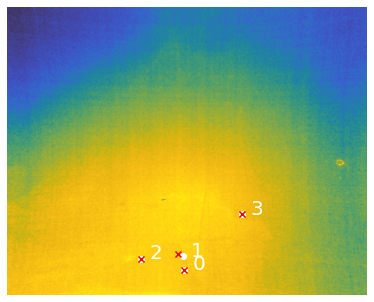

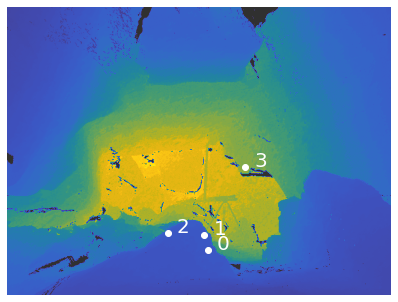

In [36]:
imIm = exp.load_imIm()
dmIm = exp.load_dmIm()
cps = exp.load_cps()

imIm[imIm > np.mean(imIm) + 2*np.std(imIm)] = np.median(imIm)

%matplotlib inline

fig1 = plt.figure(tight_layout = {'pad': 0})
ax1 = plt.gca()
ax1.imshow(imIm,cmap=cc.cm.gouldian)

ax1.scatter(cps[:,0],cps[:,1], c="white")
ax1.scatter(projs[:,0],projs[:,1],c="red",marker="x")

for i in range(projs.shape[0]):
    plt.annotate(i,(cps[i,0]+15,cps[i,1]),c="white",fontsize=20)

ax1.axis("off")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.savefig(f"annotations_{date}.png")

fig2 = plt.figure(tight_layout = {'pad': 0})
ax2 = plt.gca()
ax2.imshow(dmIm,cmap=cc.cm.gouldian)
ax2.scatter(cps[:,2],cps[:,3], c="white")
ax2.axis("off")

ax2.set_xticklabels([])
ax2.set_yticklabels([])
 
for i in range(projs.shape[0]):
    plt.annotate(i,(cps[i,2]+15,cps[i,3]),c="white",fontsize=20)

plt.tight_layout()
plt.savefig(f"annotations_{date}_depth.png")


In [14]:
dmIm.shape

(480, 640)